In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import seaborn as sns
import calendar
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
def fill_data(df, xx):
    ds = pd.DataFrame([])
    ds.index = pd.date_range(start='1960-10-03', end='2023-12-06', freq='D')

    for year in np.arange(1960, 2024):
        year_mask = ds[ds.index.year == year]
        ds.loc[year_mask.index, 'discharge'] = xx.to_numpy()[:year_mask.shape[0]]

    index = ds.index.isin(df_discharge.index)
    ds.loc[index, 'discharge'] = df
    return ds

In [4]:
file_path = 'ncei_Tacoma-Airport.csv'
df_precip = pd.read_csv(file_path)

df_precip['DATE'] = pd.to_datetime(df_precip['DATE'])

df_precip['gap'] = df_precip['PRCP'].isna()

df_precip['DATE_ordinal'] = df_precip['DATE'].apply(lambda date: date.toordinal())
imputer = KNNImputer(n_neighbors=2)

df_precip[['DATE_ordinal', 'PRCP_filled_knn']] = imputer.fit_transform(df_precip[['DATE_ordinal', 'PRCP']])

filled_rows = df_precip[df_precip['gap'] == True][['DATE', 'PRCP_filled_knn']]

df_precip

,STATION,NAME,DATE,AWND,FMTM,FRGT,PGTM,PRCP,SNOW,SNWD,...,WDFM,WESD,WSF1,WSF2,WSF5,WSFG,WSFM,gap,DATE_ordinal,PRCP_filled_knn
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-01,NaN,NaN,NaN,NaN,0.47,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711127.0,0.47
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-02,NaN,NaN,NaN,NaN,0.59,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711128.0,0.59
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-03,NaN,NaN,NaN,NaN,0.42,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711129.0,0.42
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-04,NaN,NaN,NaN,NaN,0.31,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711130.0,0.31
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-05,NaN,NaN,NaN,NaN,0.17,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711131.0,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-27,12.75,NaN,NaN,NaN,0.10,0.0,0.0,...,NaN,NaN,NaN,23.9,34.0,NaN,NaN,False,738881.0,0.10
27755,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-28,10.51,NaN,NaN,NaN,0.06,0.0,0.0,...,NaN,NaN,NaN,19.9,27.1,NaN,NaN,False,738882.0,0.06
27756,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-29,12.53,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,28.0,40.9,NaN,NaN,False,738883.0,0.00
27757,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-30,5.59,NaN,NaN,NaN,0.10,0.0,0.0,...,NaN,NaN,NaN,13.0,18.1,NaN,NaN,False,738884.0,0.10


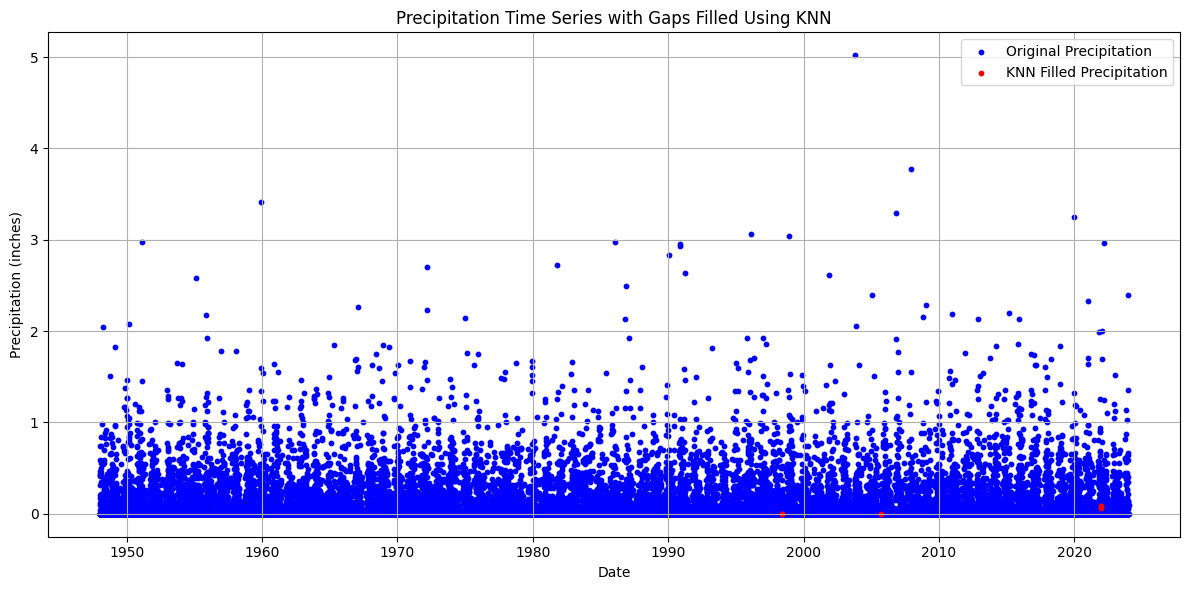

In [6]:
# Plotting
plt.figure(figsize=(12, 6))

plt.scatter(df_precip['DATE'], df_precip['PRCP'], color='blue', label='Original Precipitation', s=10)

plt.scatter(filled_rows['DATE'], filled_rows['PRCP_filled_knn'], color='red', label='KNN Filled Precipitation', s=10)

plt.title('Precipitation Time Series with Gaps Filled Using KNN')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('precipitation_time_series.png',dpi=400)
plt.show()

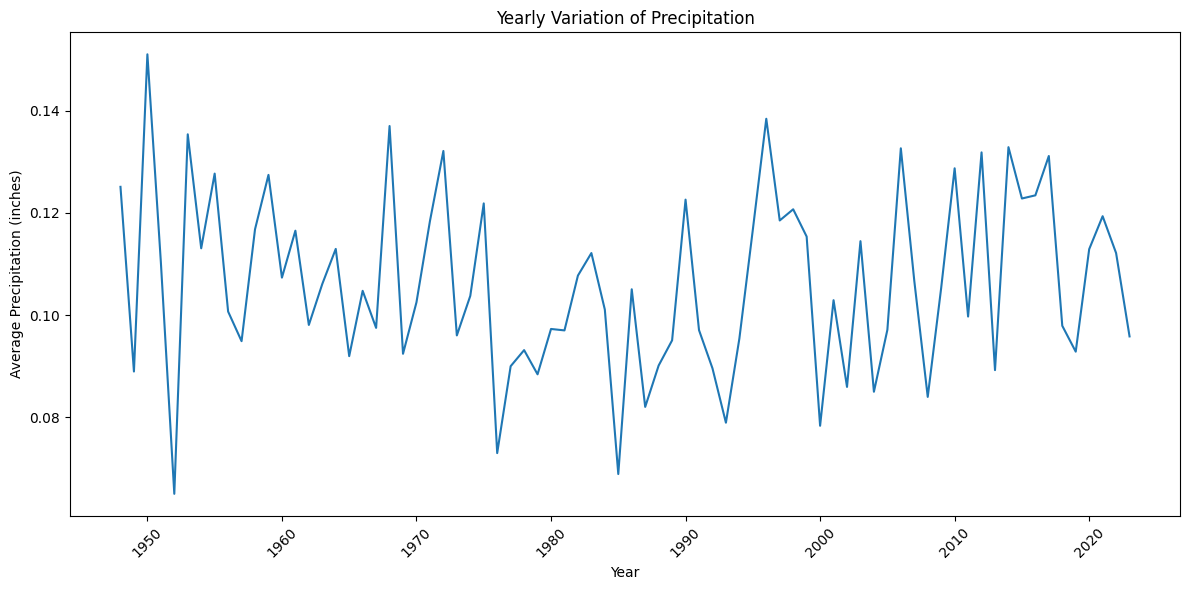

<ipython-input-12-6ae078523c00>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='PRCP_filled_knn', data=df_precip, palette='Set1', order=range(1, 13))


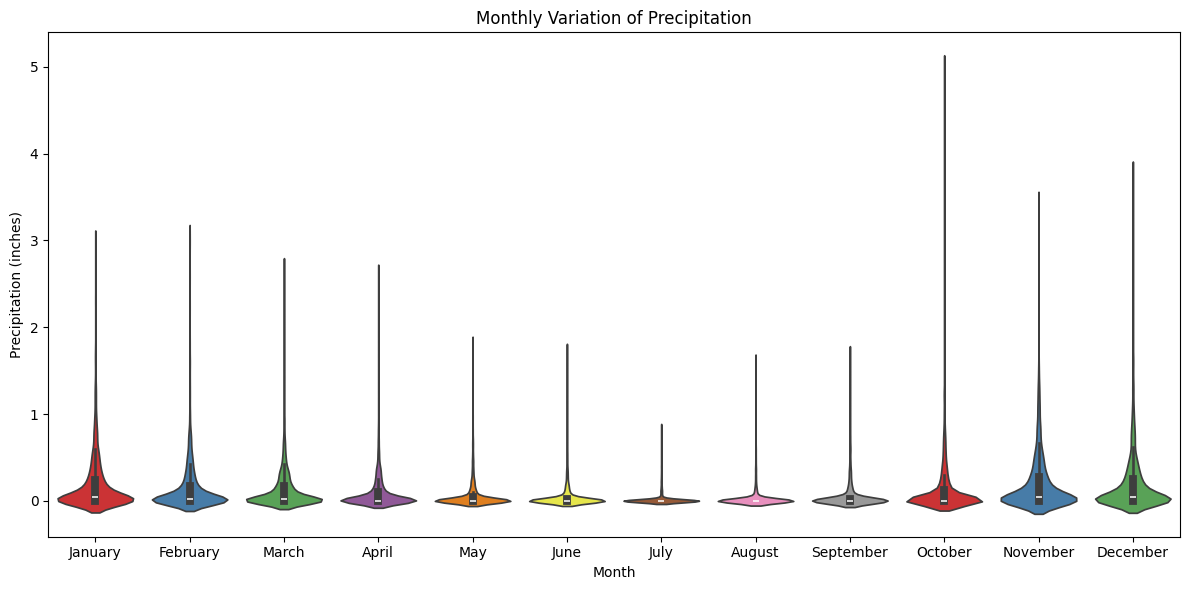

In [12]:
# Extract year and month from the DATE column
df_precip['Year'] = df_precip['DATE'].dt.year
df_precip['Month'] = df_precip['DATE'].dt.month

# Yearly variation
plt.figure(figsize=(12, 6))
df_precip.groupby('Year')['PRCP_filled_knn'].mean().plot(kind='line')
plt.title('Yearly Variation of Precipitation')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('yearly_variation.png',dpi=400)
plt.show()

# Monthly violin plot
plt.figure(figsize=(12, 6))
month_names = [calendar.month_name[i] for i in range(1, 13)]
sns.violinplot(x='Month', y='PRCP_filled_knn', data=df_precip, palette='Set1', order=range(1, 13))
plt.title('Monthly Variation of Precipitation')
plt.xlabel('Month')
plt.ylabel('Precipitation (inches)')
plt.xticks(ticks=range(12), labels=month_names)
plt.tight_layout()
plt.savefig('monthly_variation.png',dpi=400)
plt.show()


In [13]:
file_path= '12105900_Discharge_1960_2023_Daily.txt'
df_discharge = pd.read_csv(file_path, sep='\t', comment='#', skiprows=31)
df_discharge.columns = ['agency_cd', 'site_no', 'datetime', 'discharge_cfs', 'status']
df_discharge['datetime'] = pd.to_datetime(df_discharge['datetime'], errors='coerce')

In [14]:
df_discharge.index = df_discharge['datetime']
df1 = df_discharge['discharge_cfs']

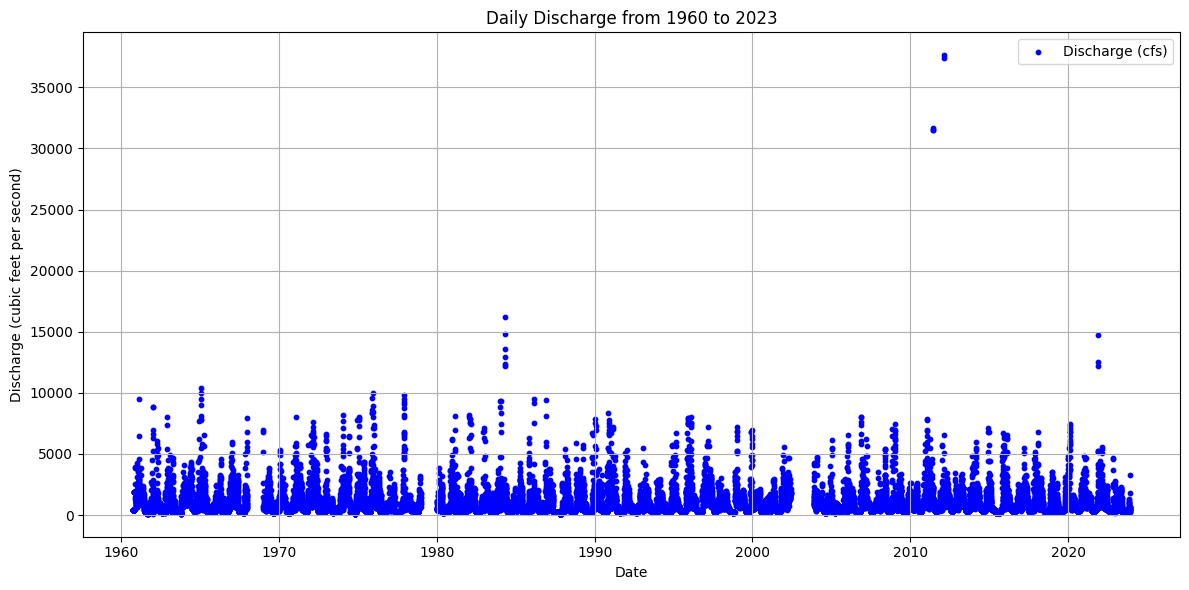

In [16]:
# plotting discharge
plt.figure(figsize=(12, 6))
plt.scatter(df1.index, df1, color='blue', s=10, label='Discharge (cfs)')
plt.title('Daily Discharge from 1960 to 2023')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('daily_discharge.png',dpi=400)
plt.show()

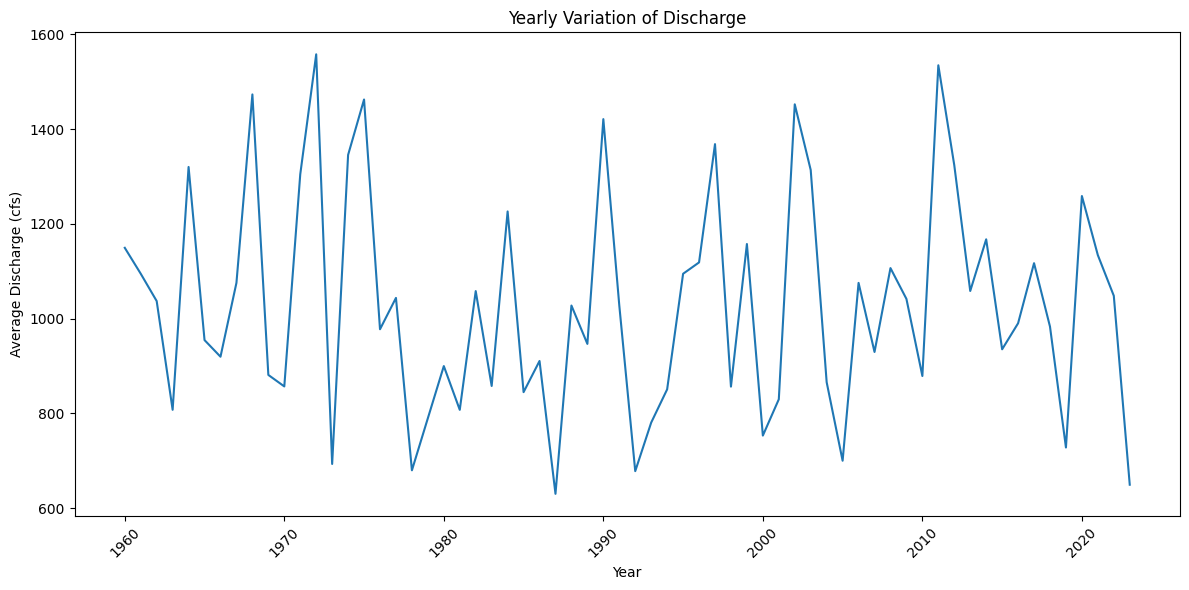

<ipython-input-17-109700cb517b>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='discharge_cfs', data=df_discharge, palette='Set1', order=range(1, 13))


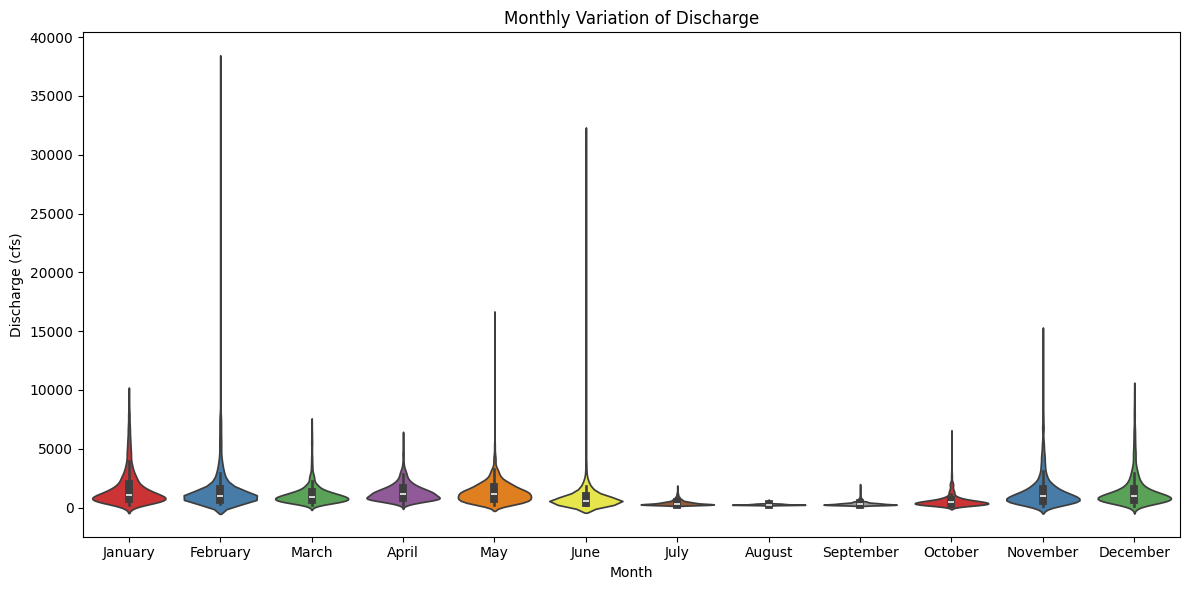

In [17]:
df_discharge['Year'] = df_discharge['datetime'].dt.year
df_discharge['Month'] = df_discharge['datetime'].dt.month

# Yearly variation
plt.figure(figsize=(12, 6))
df_discharge.groupby('Year')['discharge_cfs'].mean().plot(kind='line')
plt.title('Yearly Variation of Discharge')
plt.xlabel('Year')
plt.ylabel('Average Discharge (cfs)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('yearly_variation_discharge.png',dpi=400)
plt.show()

# Monthly violin plot
plt.figure(figsize=(12, 6))
month_names = [calendar.month_name[i] for i in range(1, 13)]
sns.violinplot(x='Month', y='discharge_cfs', data=df_discharge, palette='Set1', order=range(1, 13))
plt.title('Monthly Variation of Discharge')
plt.xlabel('Month')
plt.ylabel('Discharge (cfs)')
plt.xticks(ticks=range(12), labels=month_names)
plt.tight_layout()
plt.savefig('monthly_variation_discharge.png',dpi=400)
plt.show()


In [45]:
xx = df1.groupby(df1.index.dayofyear).mean()
xx1 = df1.groupby(df1.index.dayofyear).quantile(0.9)
xx2 = df1.groupby(df1.index.dayofyear).quantile(0.1)
ds1 = fill_data(df1, xx)
ds2 = fill_data(df1, xx1)
ds3 = fill_data(df1, xx2)

In [46]:
ds1 = fill_data(df1, xx)

gaps = ds1[~ds1.index.isin(df1.index)].index
nogaps = ds1[ds1.index.isin(df1.index)].index
nogaps

DatetimeIndex(['1960-10-03', '1960-10-04', '1960-10-05', '1960-10-06',
               '1960-10-07', '1960-10-08', '1960-10-09', '1960-10-10',
               '1960-10-11', '1960-10-12',
               ...
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06'],
              dtype='datetime64[ns]', length=21814, freq=None)

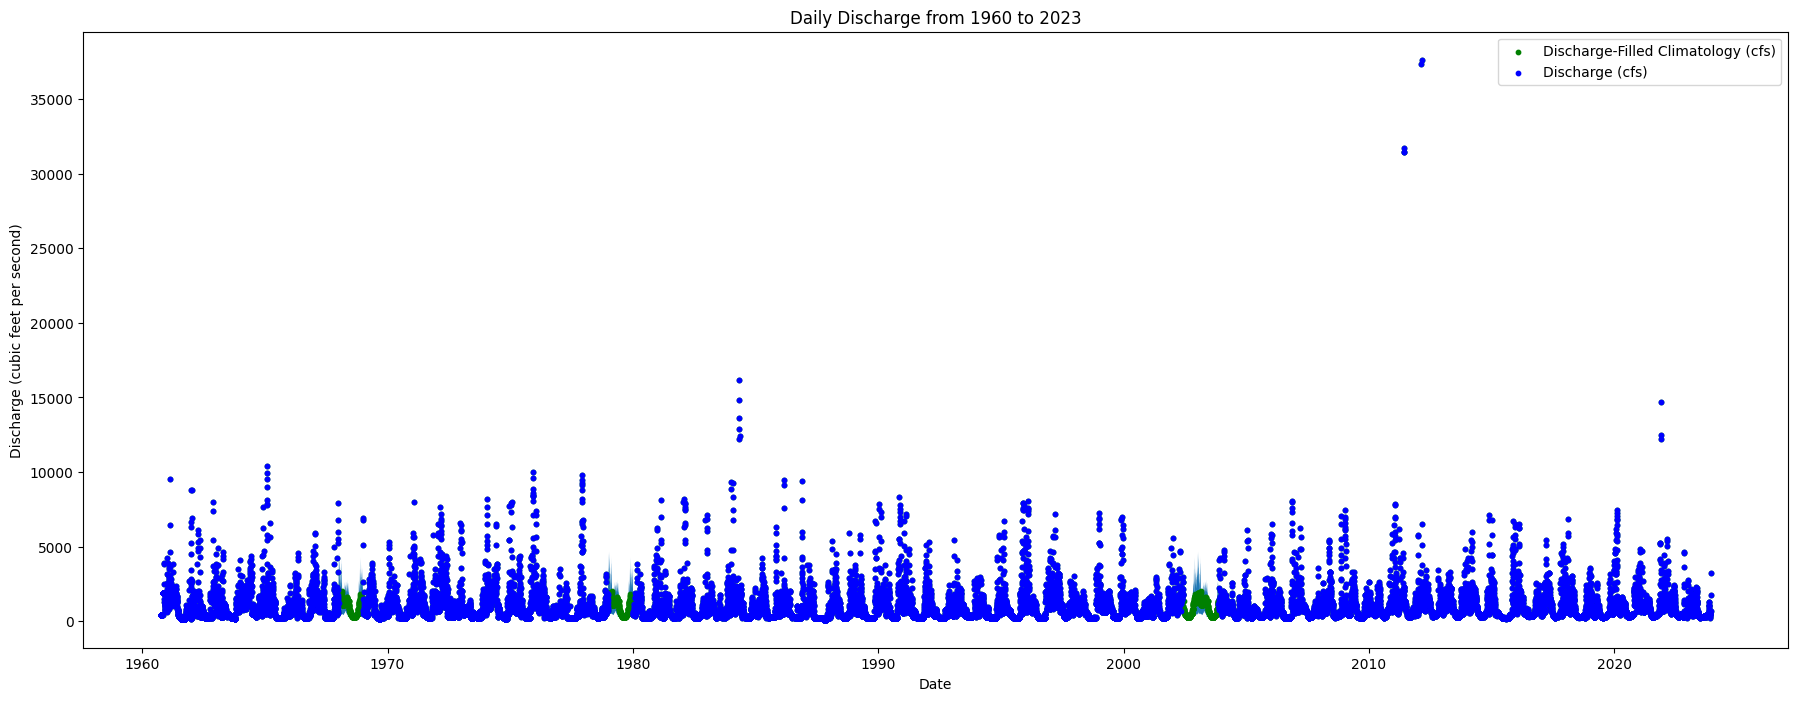

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(22, 8))

ax.fill_between(ds2.index, ds2.values.squeeze(), ds3.values.squeeze())
ax.scatter(ds1.index, ds1, color='g', s=10, label='Discharge-Filled Climatology (cfs)')
ax.scatter(df1.index, df1, color='blue', s=10, label='Discharge (cfs)')
# ax.errorbar(df_gap, ds1.loc[df_gap].to_numpy().squeeze(), yerr=(ds2.loc[df_gap]-ds3.loc[df_gap]).to_numpy().squeeze())
ax.set_title('Daily Discharge from 1960 to 2023')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (cubic feet per second)')
ax.legend()
plt.savefig('discharge_climatology.png',dpi=400)
plt.show()

In [48]:
df_precip.index = df_precip['DATE']

df_rf = ds1.copy(deep=True)
df_rf['prcp'] = df_precip.PRCP_filled_knn
df_rf['time'] = np.arange(len(df_rf))

In [49]:
train_data = df_rf.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_rf.loc[gaps, ['time', 'prcp']]

X_train = train_data[['time', 'prcp']]
y_train = train_data['discharge']

rf_model = RandomForestRegressor(n_estimators=50,min_samples_leaf=2,min_samples_split=2,max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)


if len(test_data) > 0:
    predicted_values = rf_model.predict(test_data[['time', 'prcp']])
    df_rf.loc[gaps, 'discharge'] = predicted_values

In [22]:
dsx = ds1.copy(deep=True)
ds1['day'] = np.arange(ds1.discharge.shape[0])

ds2 = ds1.loc[nogaps,:]
ds2.index = ds2.day
train_data = ds2['discharge']

ds4 = ds1.loc[gaps,:]
ds4.index = ds4.day
missing = ds4['discharge']
missing

,discharge
day,
2649,1548.283333
2650,1617.366667
2651,1584.116667
2652,1546.500000
2653,1808.050000
...,...
15742,1320.316667
15743,1340.450000
15744,1232.883333


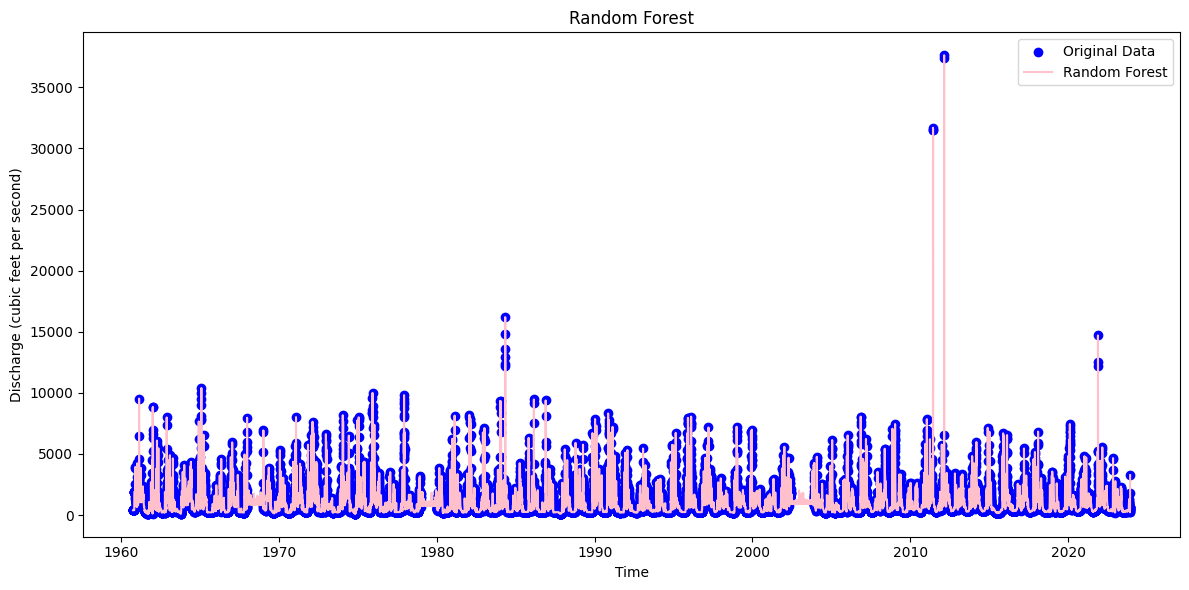

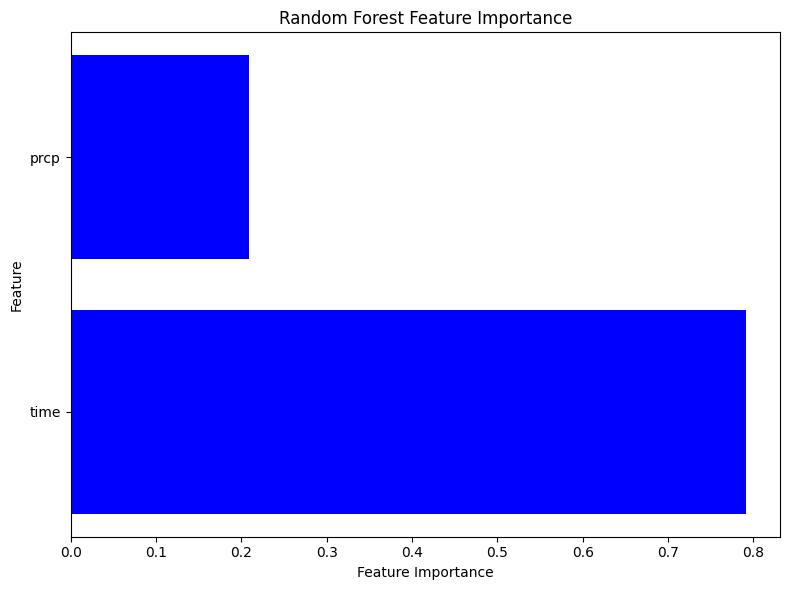

In [53]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_rf.index, df_rf['discharge'], color='pink', label='Random Forest')
plt.title('Random Forest')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.tight_layout()
plt.savefig('rf_filled_discharge.png',dpi=400)
plt.show()

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png',dpi=400)
plt.show()


 98%|===================| 21461/21814 [00:37<00:00]       

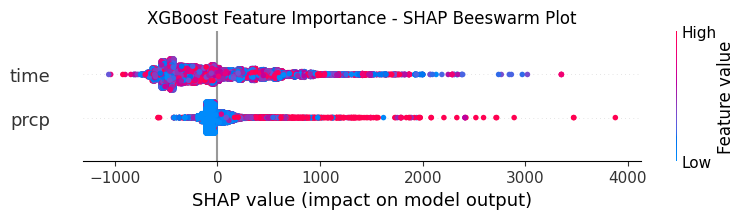

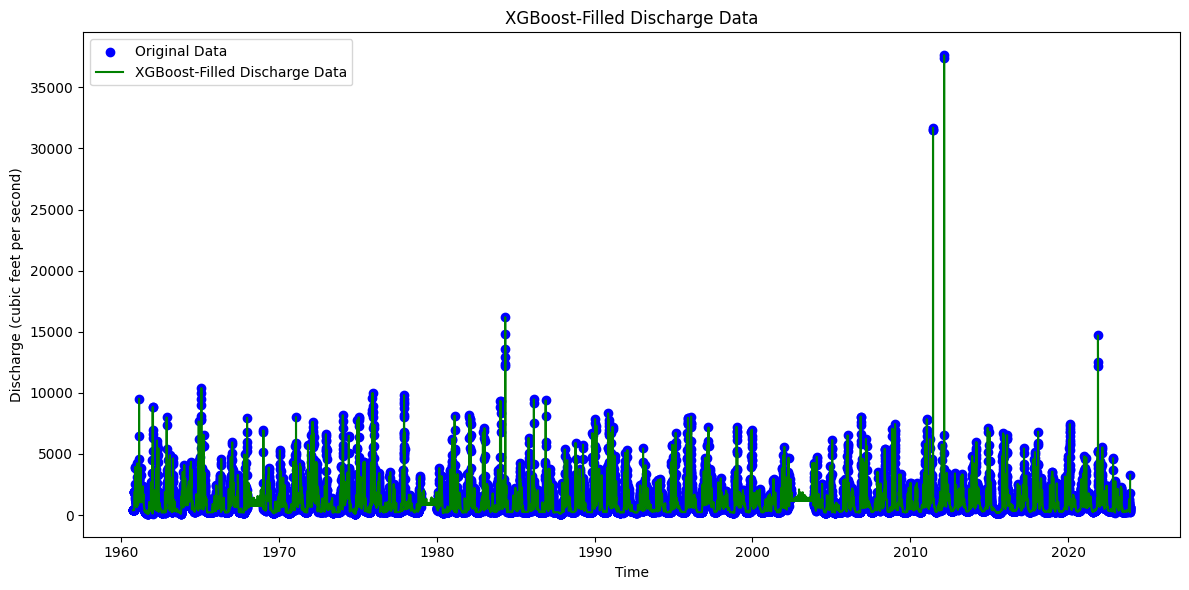

In [26]:
df_xgb = ds1.copy(deep=True)
df_xgb['prcp'] = df_precip.PRCP_filled_knn
df_xgb['time'] = np.arange(len(df_xgb))

train_data = df_xgb.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_xgb.loc[gaps, ['time', 'prcp']]

X_train = train_data[['time', 'prcp']]
y_train = train_data['discharge']

xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

if len(test_data) > 0:
    predicted_values = xgb_model.predict(test_data[['time', 'prcp']])
    df_xgb.loc[gaps, 'discharge'] = predicted_values

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.title('XGBoost Feature Importance - SHAP Beeswarm Plot')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png',dpi=400)
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_xgb.index, df_xgb['discharge'], color='g', label='XGBoost-Filled Discharge Data')
plt.title('XGBoost-Filled Discharge Data')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.tight_layout()
plt.savefig('xgb_filled_discharge.png',dpi=400)
plt.show()


In [ ]:
# Tuning Arima
#auto_model = pm.auto_arima(train_data,
#                           start_p=1, start_q=1,
#                           max_p=5, max_q=5,
#                           d=None,  # Let auto_arima choose differencing
#                           seasonal=True,  # Set to True for seasonal data
#                           stepwise=True,
#                           trace=True)

#print(f"Best ARIMA order: {auto_model.order}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
<ipython-input-50-6e18008725f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

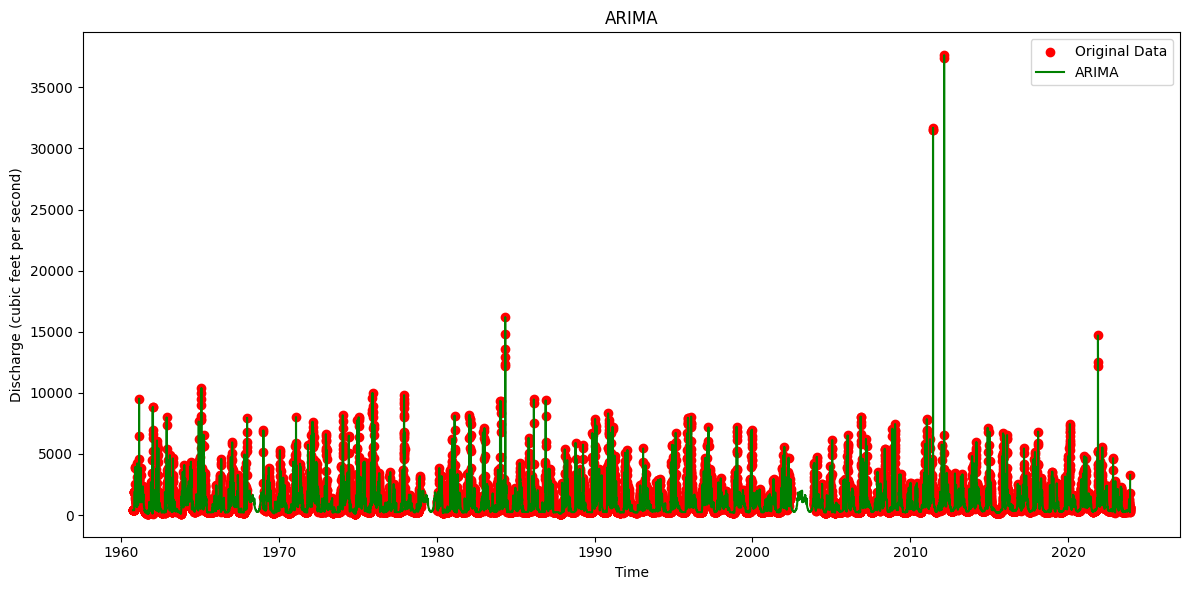

In [50]:
model = ARIMA(train_data['discharge'], order=(1, 1, 1))
model_fit = model.fit()
predicted_values = model_fit.predict(start=missing.index[0], end=missing.index[-1])
dsx.iloc[missing]['discharge'] = predicted_values
# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='r', label='Original Data')
plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA')

plt.title('ARIMA')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.savefig('arima_filled_discharge.png',dpi=400)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


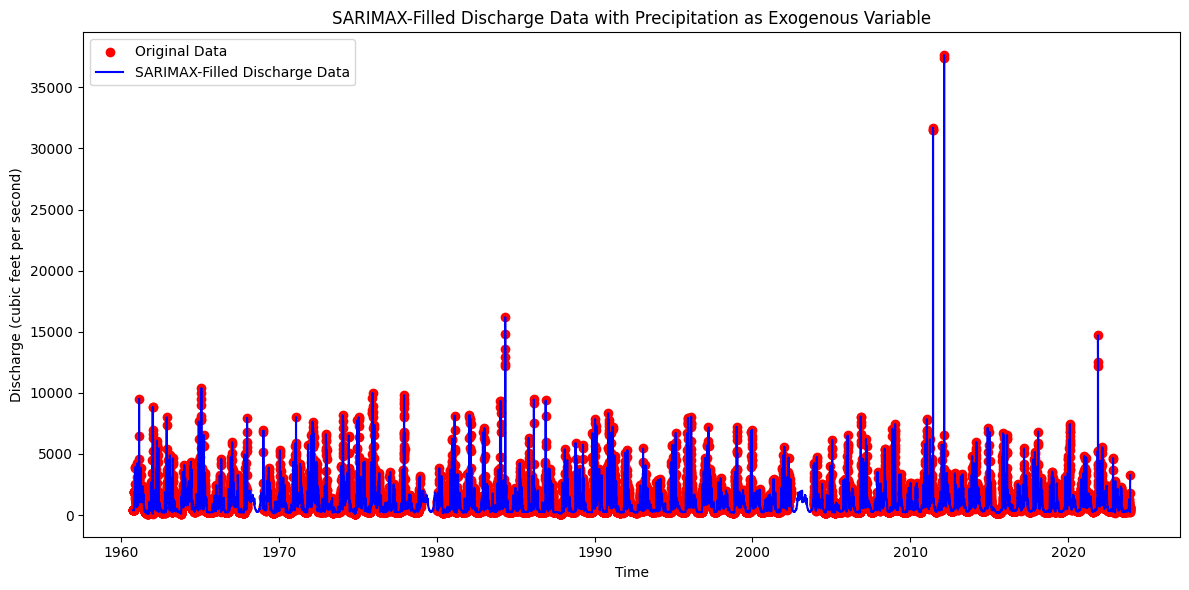

In [52]:
df_sarimax = ds1.copy(deep=True)
df_sarimax['prcp'] = df_precip.PRCP_filled_knn
df_sarimax['time'] = np.arange(len(df_sarimax))

train_data = df_sarimax.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_sarimax.loc[gaps, ['time', 'prcp']]

model = SARIMAX(train_data['discharge'], exog=train_data['prcp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

if len(test_data) > 0:
    predictions = model_fit.get_forecast(steps=len(test_data), exog=test_data['prcp'])
    predicted_values = predictions.predicted_mean

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='r', label='Original Data')
plt.plot(df_sarimax.index, df_sarimax['discharge'], color='b', label='SARIMAX-Filled Discharge Data')
plt.title('SARIMAX-Filled Discharge Data with Precipitation as Exogenous Variable')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.savefig('sarimax_filled_discharge.png',dpi=400)
plt.tight_layout()
plt.show()


In [29]:
predicted_values = model_fit.predict(start=missing.index[0], end=missing.index[-1])

dsx.iloc[missing]['discharge'] = predicted_values

<ipython-input-29-d98c96887a15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsx.iloc[missing]['discharge'] = predicted_values


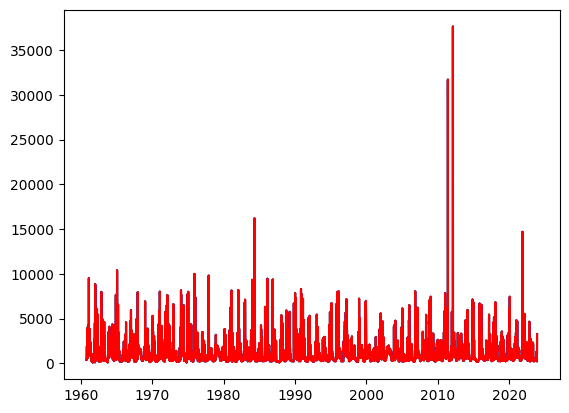

In [39]:
plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA')
plt.plot(df_sarimax.index, df_sarimax['discharge'], color='b', label='SARIMAX')
plt.plot(ds1.index, ds1.discharge, color='r', label='climatology')

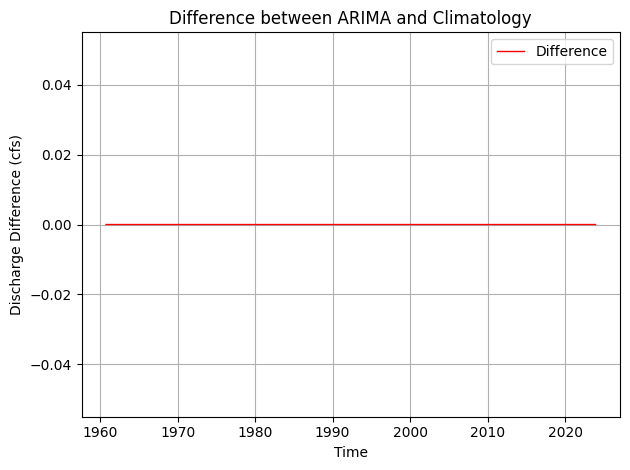

In [40]:
plt.plot(dsx.index, dsx['discharge'] - ds1.discharge, color='r', label='Difference', lw=1)
plt.title('Difference between ARIMA and Climatology')
plt.xlabel('Time')
plt.ylabel('Discharge Difference (cfs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


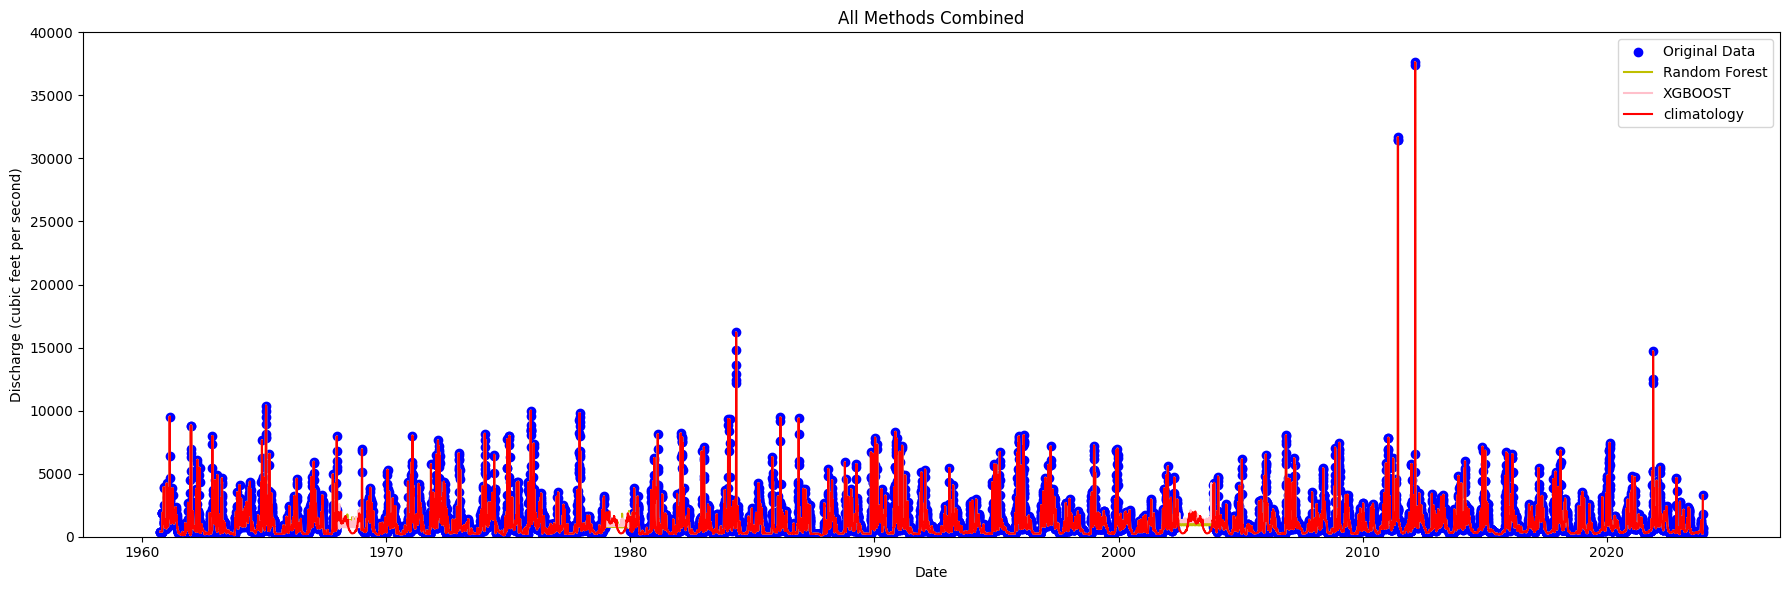

In [54]:
plt.figure(figsize=(18, 6))

plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_rf.index, df_rf['discharge'], color='y', label='Random Forest')
plt.plot(df_xgb.index,df_xgb['discharge'],color='pink',label='XGBOOST')
#plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA')
#plt.plot(df_sarimax.index, df_sarimax['discharge'], color='c', label='SARIMAX')
plt.plot(ds1.index, ds1.discharge, color='r', label='climatology')

# Plotting
plt.title('All Methods Combined')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
#plt.xlim(pd.to_datetime('2002-01-03'), pd.to_datetime('2004-01-06'))
plt.ylim(0, 40000)
plt.tight_layout()
plt.savefig('all_filled__RF_XGB_Clim_discharge.png',dpi=400)
plt.show()

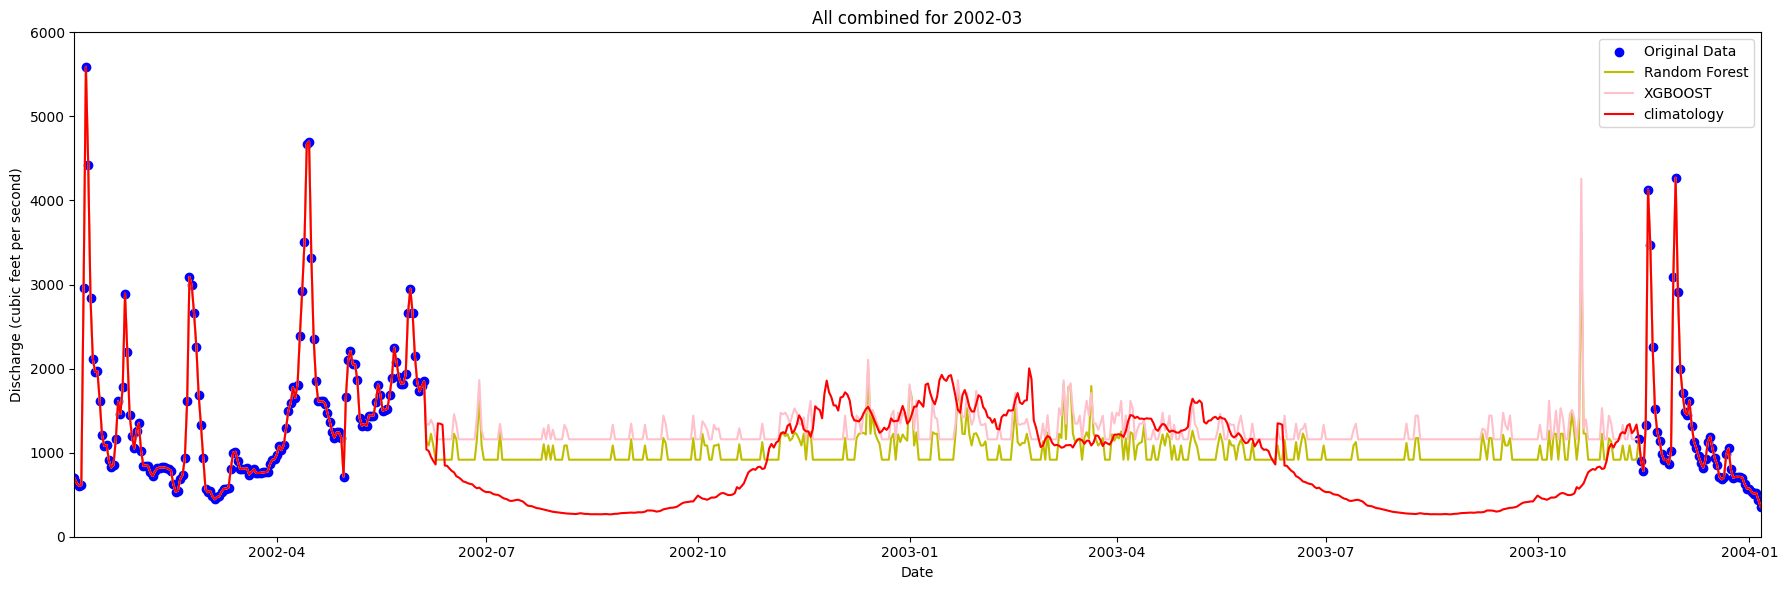

In [55]:
plt.figure(figsize=(18, 6))

plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_rf.index, df_rf['discharge'], color='y', label='Random Forest')
plt.plot(df_xgb.index,df_xgb['discharge'],color='pink',label='XGBOOST')
#plt.plot(df_sarimax.index, df_sarimax['discharge'], color='c', label='SARIMAX')
#plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA')
plt.plot(ds1.index, ds1.discharge, color='r', label='climatology')

# Plotting
plt.title('All combined for 2002-03')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.xlim(pd.to_datetime('2002-01-03'), pd.to_datetime('2004-01-06'))
plt.ylim(0, 6000)
plt.tight_layout()
plt.savefig('all_filled_discharge_2002_xgb_rf_clim.png',dpi=400)
plt.show()